In [1]:
#Imports
from pandas import read_csv
import pandas

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Linear Classification Algorithms
from sklearn.linear_model import LogisticRegression #Logistic Regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #Linear Discriminant Analysis

#Non-Linear Classification Algorithms
from sklearn.neighbors import KNeighborsClassifier #Nearest Neighbors
from sklearn.naive_bayes import GaussianNB #Naive Bayes
from sklearn.tree import DecisionTreeClassifier #Classification and Regression Trees
from sklearn.svm import SVC #Support Vector Machines

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from joblib import dump
from joblib import load

import numpy

from matplotlib import pyplot

In [2]:
#Load Data
filenameFire = 'fire.csv'
filenameIndexes = 'indexes.csv'
filenameLocation = 'location.csv'
filenameMeteorology = 'meteorological_conditions.csv'
filenameTime = 'time.csv'

namesFire = ['id', 'burned_area', 'location_id', 'indexes_id', 'meteorological_conditions_id', 'time_id']
namesIndexes = ['id', 'ffmc', 'dmc', 'dc', 'isi']
namesLocation = ['id', 'X', 'Y', 'locationnswe']
namesMeteorology = ['id', 'relative_humidity', 'wind_speed', 'accumulated_precipitation', 'temperature']
namesTime = ['id', 'day_week', 'weekend', 'month', 'season']

fireDataframe = read_csv(filenameFire, names = namesFire, sep = ";", header = 0)
indexesDataframe = read_csv(filenameIndexes, names = namesIndexes, sep = ";", header = 0)
locationDataframe = read_csv(filenameLocation, names = namesLocation, sep = ";", header = 0)
meteorologyDataframe = read_csv(filenameMeteorology, names = namesMeteorology, sep = ";", header = 0)
timeDataframe = read_csv(filenameTime, names = namesTime, sep = ";", header = 0)

#Drop unused columns
locationDataframe = locationDataframe.drop("locationnswe", 1)
timeDataframe = timeDataframe.drop("weekend", 1)
timeDataframe = timeDataframe.drop("season", 1)

#Put ids as ints
fireDataframe.id = fireDataframe.id.astype(int)
fireDataframe.location_id = fireDataframe.location_id.astype(int)
fireDataframe.indexes_id = fireDataframe.indexes_id.astype(int)
fireDataframe.meteorological_conditions_id = fireDataframe.meteorological_conditions_id.astype(int)
fireDataframe.time_id = fireDataframe.time_id.astype(int)

indexesDataframe.id = indexesDataframe.id.astype(int)
locationDataframe.id = locationDataframe.id.astype(int)
meteorologyDataframe.id = meteorologyDataframe.id.astype(int)
timeDataframe.id = timeDataframe.id.astype(int)

In [3]:
#Pre-processing 1 - Fixing the issue of having fewer rows in the dimensions

#Since we removed duplicates in the dimensions during ETL (e.g. repeated combinations of day of the week and 
#month), we first need to match the ids from each dimension to the ids in the fireDataframe, to create new 
#dataframes with the same number of rows as the fireDataframe

indexesDataframe2 = pandas.DataFrame(columns = namesIndexes)
locationDataframe2 = pandas.DataFrame(columns = namesLocation)
meteorologyDataframe2 = pandas.DataFrame(columns = namesMeteorology)
timeDataframe2 = pandas.DataFrame(columns = namesTime)

#Drop Unused columns from new dataframes
locationDataframe2 = locationDataframe2.drop("locationnswe", 1)
timeDataframe2 = timeDataframe2.drop("weekend", 1)
timeDataframe2 = timeDataframe2.drop("season", 1)

indexesDataframe2 = indexesDataframe2.drop("id", 1)
locationDataframe2 = locationDataframe2.drop("id", 1)
meteorologyDataframe2 = meteorologyDataframe2.drop("id", 1)
timeDataframe2 = timeDataframe2.drop("id", 1)

length = len(fireDataframe)

for i in range(length):    
    position = fireDataframe.indexes_id[i] - 1
    ffmc = indexesDataframe.ffmc[position]
    dmc = indexesDataframe.dmc[position]
    dc = indexesDataframe.dc[position]
    isi = indexesDataframe.isi[position]
    new_row = {'ffmc':ffmc, 'dmc':dmc, 'dc':dc, 'isi':isi}
    indexesDataframe2 = indexesDataframe2.append(new_row, ignore_index=True)
    
    position = fireDataframe.location_id[i] - 1
    x = locationDataframe.X[position]
    y = locationDataframe.Y[position]
    new_row = {'X':x, 'Y':y}
    locationDataframe2 = locationDataframe2.append(new_row, ignore_index=True)
    
    position = fireDataframe.meteorological_conditions_id[i] - 1
    relative_humidity = meteorologyDataframe.relative_humidity[position]
    wind_speed = meteorologyDataframe.wind_speed[position]
    accumulated_precipitation = meteorologyDataframe.accumulated_precipitation[position]
    temperature = meteorologyDataframe.temperature[position]
    new_row = {'relative_humidity':relative_humidity, 'wind_speed':wind_speed, 'accumulated_precipitation':accumulated_precipitation, 'temperature':temperature}
    meteorologyDataframe2 = meteorologyDataframe2.append(new_row, ignore_index=True)
    
    position = fireDataframe.time_id[i] - 1
    day_week = timeDataframe.day_week[position]
    month = timeDataframe.month[position]
    new_row = {'day_week':day_week, 'month':month}
    timeDataframe2 = timeDataframe2.append(new_row, ignore_index=True)
    
indexesDataframe = indexesDataframe2
locationDataframe = locationDataframe2
meteorologyDataframe = meteorologyDataframe2
timeDataframe = timeDataframe2

#Drop ids since they are no longer needed
fireDataframe = fireDataframe.drop("id", 1)
fireDataframe = fireDataframe.drop("location_id", 1)
fireDataframe = fireDataframe.drop("indexes_id", 1)
fireDataframe = fireDataframe.drop("meteorological_conditions_id", 1)
fireDataframe = fireDataframe.drop("time_id", 1)

In [4]:
#Pre-processing 2 - Convert 'day_week' and 'month' so they are usable

timeDataframe.loc[timeDataframe["day_week"] == "mon", "day_week"] = 0
timeDataframe.loc[timeDataframe["day_week"] == "tue", "day_week"] = 1
timeDataframe.loc[timeDataframe["day_week"] == "wed", "day_week"] = 2
timeDataframe.loc[timeDataframe["day_week"] == "thu", "day_week"] = 3
timeDataframe.loc[timeDataframe["day_week"] == "fri", "day_week"] = 4
timeDataframe.loc[timeDataframe["day_week"] == "sat", "day_week"] = 5
timeDataframe.loc[timeDataframe["day_week"] == "sun", "day_week"] = 6

timeDataframe.loc[timeDataframe["month"] == "jan", "month"] = 0
timeDataframe.loc[timeDataframe["month"] == "feb", "month"] = 1
timeDataframe.loc[timeDataframe["month"] == "mar", "month"] = 2
timeDataframe.loc[timeDataframe["month"] == "apr", "month"] = 3
timeDataframe.loc[timeDataframe["month"] == "may", "month"] = 4
timeDataframe.loc[timeDataframe["month"] == "jun", "month"] = 5
timeDataframe.loc[timeDataframe["month"] == "jul", "month"] = 6
timeDataframe.loc[timeDataframe["month"] == "aug", "month"] = 7
timeDataframe.loc[timeDataframe["month"] == "sep", "month"] = 8
timeDataframe.loc[timeDataframe["month"] == "oct", "month"] = 9
timeDataframe.loc[timeDataframe["month"] == "nov", "month"] = 10
timeDataframe.loc[timeDataframe["month"] == "dec", "month"] = 11

timeDataframe.day_week = timeDataframe.day_week.astype(int)
timeDataframe.month = timeDataframe.month.astype(int)

In [5]:
#Pre-processing 3 - Inverse of ln(x+1)

indexesDataframe.ffmc = numpy.exp(indexesDataframe.ffmc) - 1
indexesDataframe.ffmc = indexesDataframe.ffmc.clip(lower=0) #If negative -> 0

indexesDataframe.dmc = numpy.exp(indexesDataframe.dmc) - 1
indexesDataframe.dmc = indexesDataframe.dmc.clip(lower=0) #If negative -> 0

indexesDataframe.dc = numpy.exp(indexesDataframe.dc) - 1
indexesDataframe.dc = indexesDataframe.dc.clip(lower=0) #If negative -> 0

fireDataframe.burned_area = numpy.exp(fireDataframe.burned_area) - 1
fireDataframe.burned_area = fireDataframe.burned_area.clip(lower=0) #If negative -> 0

In [6]:
#Pre-processing 4 - Create dataframe that will be used for classification

#The idea is to classify whether an area is burned or not, to access danger related with fire when given certain inputs

#If no area was burned by the fire -> 0
#Else -> 1

namesBA = ['burned_area']
booleanBurnedAreaDataframe = pandas.DataFrame(columns = namesBA)
booleanBurnedAreaDataframe.burned_area = fireDataframe.burned_area

booleanBurnedAreaDataframe.burned_area = booleanBurnedAreaDataframe.burned_area.astype(int)

booleanBurnedAreaDataframe.loc[booleanBurnedAreaDataframe["burned_area"] > 0, "burned_area"] = 1
booleanBurnedAreaDataframe.loc[booleanBurnedAreaDataframe["burned_area"] == 0, "burned_area"] = 0

In [7]:
#Get values from the dataframe

indexes = indexesDataframe.values
location = locationDataframe.values
meteorology = meteorologyDataframe.values
time = timeDataframe.values

booleanBurnedArea = booleanBurnedAreaDataframe.values
fire = fireDataframe.values

In [8]:
#Pre-processing 5 - Separate array into input and output components

LT = numpy.concatenate( (location[:,0:2], time[:,0:2]), axis=1) #location and time
LTM = numpy.concatenate( (location[:,0:2], time[:,0:2], meteorology[:,0:4]), axis=1) #location, time and meteorology
LTCM = numpy.concatenate( (location[:,0:2], time[:,0:2], indexes[:,0:4], meteorology[:,0:4]), axis=1) #location, time, Canadian indexes and meteorology
LCM = numpy.concatenate( (location[:,0:2], indexes[:,0:4], meteorology[:,0:4]), axis=1) #location, Canadian indexes and meteorology
M = meteorology[:,0:4] #meteorology

Y = booleanBurnedArea[:,0]

In [9]:
#Pre-processing 6 - Standardize the data

#Standardize the data - Min-max feature scaling (0, 1)
#scaler = MinMaxScaler(feature_range=(0, 1))
#LT = scaler.fit_transform(LT)

#Standardize data (0 mean, 1 stdev)
LT = StandardScaler().fit_transform(LT)
LTM = StandardScaler().fit_transform(LTM)
LTCM = StandardScaler().fit_transform(LTCM)
LCM = StandardScaler().fit_transform(LCM)
M = StandardScaler().fit_transform(M)

featuresSelected = []

featuresSelected.append(('Location, Time', LT, [], []))
featuresSelected.append(('Location, Time, Meteorology', LTM, [], []))
featuresSelected.append(('Location, Time, Canadian Indexes, Meteorology', LTCM, [], []))
featuresSelected.append(('Location, Canadian Indexes, Meteorology', LCM, [], []))
featuresSelected.append(('Meteorology', M, [], []))

## Classification Algorithms Comparison

In [10]:
#Prepare models
models = []

models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(C=10.0, gamma=0.00001)))

In [11]:
#Evaluate each model in turn
results = []
names = []

scoring = 'accuracy'
#scoring = 'balanced_accuracy'
#scoring = 'f1' #f1 score

for nameFeaturesSelected,featuresS,results,names in featuresSelected:
    print("Features Selected Setup: " + nameFeaturesSelected, end = "\n\n")
    for name, model in models:
        kfold = KFold(n_splits=10)
        cv_results = cross_val_score(model, LT, Y, cv=kfold, scoring=scoring)
        
    
        results.append(cv_results)
        names.append(name)
        msg = '%s: %.3f (%.3f)' % (name, cv_results.mean()*100, cv_results.std()*100)
        print(msg, end = '\n\n')
    print("\n")

Features Selected Setup: Location, Time

LR: 37.368 (16.458)

LDA: 37.564 (16.373)

KNN: 43.164 (9.057)

CART: 42.952 (5.604)

NB: 38.733 (11.453)

SVM: 26.022 (19.836)



Features Selected Setup: Location, Time, Meteorology

LR: 37.368 (16.458)

LDA: 37.564 (16.373)

KNN: 43.164 (9.057)

CART: 42.756 (4.681)

NB: 38.733 (11.453)

SVM: 26.022 (19.836)



Features Selected Setup: Location, Time, Canadian Indexes, Meteorology

LR: 37.368 (16.458)

LDA: 37.564 (16.373)

KNN: 43.164 (9.057)

CART: 42.568 (5.635)

NB: 38.733 (11.453)

SVM: 26.022 (19.836)



Features Selected Setup: Location, Canadian Indexes, Meteorology

LR: 37.368 (16.458)

LDA: 37.564 (16.373)

KNN: 43.164 (9.057)

CART: 42.756 (5.356)

NB: 38.733 (11.453)

SVM: 26.022 (19.836)



Features Selected Setup: Meteorology

LR: 37.368 (16.458)

LDA: 37.564 (16.373)

KNN: 43.164 (9.057)

CART: 41.399 (3.731)

NB: 38.733 (11.453)

SVM: 26.022 (19.836)





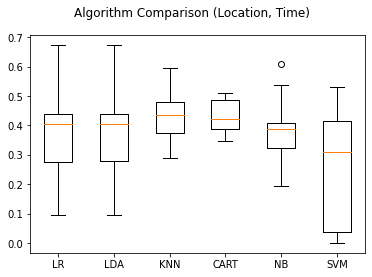

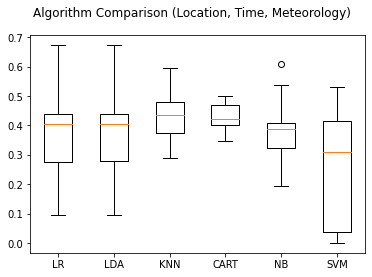

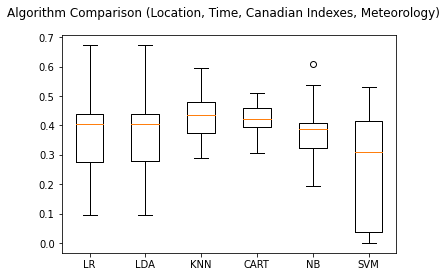

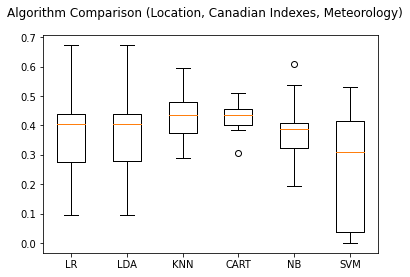

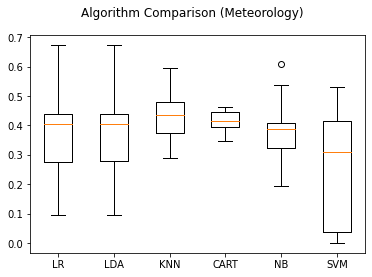

In [12]:
#Boxplot algorithm comparison

for nameFeaturesSelected,featuresS,results,names in featuresSelected: 
    fig = pyplot.figure()
    fig.suptitle('Algorithm Comparison (' + nameFeaturesSelected + ')')
    ax = fig.add_subplot(111)
    pyplot.boxplot(results)
    ax.set_xticklabels(names)
    pyplot.show()

In [13]:
for nameFeaturesSelected,featuresS,results,names in featuresSelected:
    
    print('Algorithm Comparison (' + nameFeaturesSelected + ')')
    
    for name, model in models:
        print('\n' + name)
        model.fit(featuresS,Y)
        ypred = model.predict(featuresS)
        
        print('Result using ((1-((Y-ypred)**2).mean())*100) for higher accuracy', end = ': ')
        print((1-((Y-ypred)**2).mean())*100, end = '\n\n') #using training data labels (accuracy is higher)
        
        print('Confusion Matrix')
        matrix = confusion_matrix(Y,ypred)
        print(matrix, end = '\n')

        target_names = ['No Burned Area', 'Burned Area']
        print(classification_report(Y, ypred, target_names=target_names), end = '\n')

Algorithm Comparison (Location, Time)

LR
Result using ((1-((Y-ypred)**2).mean())*100) for higher accuracy: 54.15860735009671

Confusion Matrix
[[185  89]
 [148  95]]
                precision    recall  f1-score   support

No Burned Area       0.56      0.68      0.61       274
   Burned Area       0.52      0.39      0.44       243

      accuracy                           0.54       517
     macro avg       0.54      0.53      0.53       517
  weighted avg       0.54      0.54      0.53       517


LDA
Result using ((1-((Y-ypred)**2).mean())*100) for higher accuracy: 54.15860735009671

Confusion Matrix
[[185  89]
 [148  95]]
                precision    recall  f1-score   support

No Burned Area       0.56      0.68      0.61       274
   Burned Area       0.52      0.39      0.44       243

      accuracy                           0.54       517
     macro avg       0.54      0.53      0.53       517
  weighted avg       0.54      0.54      0.53       517


KNN
Result using ((1-((Y

c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Result using ((1-((Y-ypred)**2).mean())*100) for higher accuracy: 52.99806576402322

Confusion Matrix
[[274   0]
 [243   0]]
                precision    recall  f1-score   support

No Burned Area       0.53      1.00      0.69       274
   Burned Area       0.00      0.00      0.00       243

      accuracy                           0.53       517
     macro avg       0.26      0.50      0.35       517
  weighted avg       0.28      0.53      0.37       517

Algorithm Comparison (Location, Time, Canadian Indexes, Meteorology)

LR
Result using ((1-((Y-ypred)**2).mean())*100) for higher accuracy: 55.51257253384914

Confusion Matrix
[[195  79]
 [151  92]]
                precision    recall  f1-score   support

No Burned Area       0.56      0.71      0.63       274
   Burned Area       0.54      0.38      0.44       243

      accuracy                           0.56       517
     macro avg       0.55      0.55      0.54       517
  weighted avg       0.55      0.56      0.54       517


c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Result using ((1-((Y-ypred)**2).mean())*100) for higher accuracy: 52.99806576402322

Confusion Matrix
[[274   0]
 [243   0]]
                precision    recall  f1-score   support

No Burned Area       0.53      1.00      0.69       274
   Burned Area       0.00      0.00      0.00       243

      accuracy                           0.53       517
     macro avg       0.26      0.50      0.35       517
  weighted avg       0.28      0.53      0.37       517

Algorithm Comparison (Location, Canadian Indexes, Meteorology)

LR
Result using ((1-((Y-ypred)**2).mean())*100) for higher accuracy: 54.932301740812385

Confusion Matrix
[[192  82]
 [151  92]]
                precision    recall  f1-score   support

No Burned Area       0.56      0.70      0.62       274
   Burned Area       0.53      0.38      0.44       243

      accuracy                           0.55       517
     macro avg       0.54      0.54      0.53       517
  weighted avg       0.55      0.55      0.54       517


LDA

c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Result using ((1-((Y-ypred)**2).mean())*100) for higher accuracy: 52.99806576402322

Confusion Matrix
[[274   0]
 [243   0]]
                precision    recall  f1-score   support

No Burned Area       0.53      1.00      0.69       274
   Burned Area       0.00      0.00      0.00       243

      accuracy                           0.53       517
     macro avg       0.26      0.50      0.35       517
  weighted avg       0.28      0.53      0.37       517

Algorithm Comparison (Meteorology)

LR
Result using ((1-((Y-ypred)**2).mean())*100) for higher accuracy: 53.38491295938104

Confusion Matrix
[[223  51]
 [190  53]]
                precision    recall  f1-score   support

No Burned Area       0.54      0.81      0.65       274
   Burned Area       0.51      0.22      0.31       243

      accuracy                           0.53       517
     macro avg       0.52      0.52      0.48       517
  weighted avg       0.53      0.53      0.49       517


LDA
Result using ((1-((Y-ypred)*

c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

: 52.99806576402322

Confusion Matrix
[[274   0]
 [243   0]]
                precision    recall  f1-score   support

No Burned Area       0.53      1.00      0.69       274
   Burned Area       0.00      0.00      0.00       243

      accuracy                           0.53       517
     macro avg       0.26      0.50      0.35       517
  weighted avg       0.28      0.53      0.37       517



c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filipe miguel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [14]:
#save the model to disk

#for nameFeaturesSelected,featuresS,results,names in featuresSelected:
    
    #for name, model in models:
        #filename = 'ModelsClassification\\' + name + ' (' + nameFeaturesSelected + ').sav'
        #dump(model, filename)

In [15]:
#Some time later -> Load the model from disk
#loaded_model = load(filename)